In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import re
from copy import copy
import seaborn as sns

## Download Data

In [2]:
# download train
files = os.listdir('reuters/training/')
files = sorted([int(i) for i in files])
text = []
for file in tqdm(files):
    with open('reuters/training/' + str(file), 'r') as f:
        temp = f.readlines()
        temp = ' '.join(temp).replace('\n', ' ')
        text.append(temp)

text = np.array(text)
print(text.shape)

100%|██████████| 7769/7769 [00:03<00:00, 2561.21it/s]

(7769,)


In [3]:
# categories
cats = []
with open('reuters/cats.txt', 'r') as cats_file:
    for i in tqdm(cats_file):
        if 'training/' in i:
            cat = ' '.join(i.split()[1:])
            cats.append(cat)

cats = np.array(cats)
print(cats.shape)

10788it [00:00, 721143.54it/s]

(7769,)


In [4]:
# stopwords
with open('reuters/stopwords', 'r') as f:
    temp = f.readlines()
stopwords_reuters = [i.replace('\n', '') for i in temp]

## EDA

In [5]:
# lowercase
for i in range(len(text)):
    text[i] = np.char.lower(text[i])

In [6]:
# stopwords
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
res_stopwords = stopwords.words('english') + stopwords_reuters

for i in tqdm(range(len(text))):
    temp = text[i].split()
    new_text = ''
    for word in temp:
        if word not in res_stopwords:
            new_text = new_text + " " + word
        text[i] = new_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maksim_Krug\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 7769/7769 [00:08<00:00, 881.76it/s]


In [7]:
# punctuation
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
for i in tqdm(range(len(text))):
    text[i] = ' '.join(tokenizer.tokenize(text[i]))

100%|██████████| 7769/7769 [00:00<00:00, 19728.39it/s]


In [8]:
# single character
for i in tqdm(range(len(text))):
    temp = text[i].split()
    new_text = ''
    for word in temp:
        if len(word) > 1:
            new_text = new_text + " " + word
    text[i] = new_text

100%|██████████| 7769/7769 [00:00<00:00, 18007.68it/s]


In [9]:
# stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
for i in tqdm(range(len(text))):
    temp = text[i].split()
    new_text = ''
    for word in temp:
        new_text = new_text + " " + stemmer.stem(word)
    text[i] = new_text

100%|██████████| 7769/7769 [00:11<00:00, 655.16it/s]


In [10]:
# получим все уникальные слова
UniqueWords = set()
for i in range(len(text)):
    words = text[i].split()
    words = set(words)
    UniqueWords = UniqueWords.union(words)
    
print('Num Unique Words: {}'.format(len(UniqueWords)))

Num Unique Words: 19658


In [11]:
# посмотрим что с распределением количества слов
num_words = dict.fromkeys(UniqueWords, 0)
for i in tqdm(range(len(text))):
    for word in text[i].split():
        num_words[word] += 1

100%|██████████| 7769/7769 [00:00<00:00, 26507.06it/s]


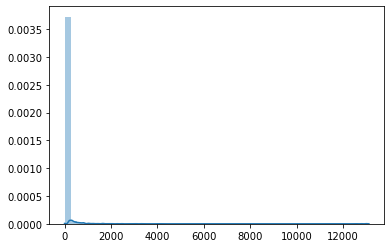

In [12]:
sns.distplot(list(num_words.values()));

Распределение выглядит плохо, давайте просто удалим по 5% сверху и снизу

In [13]:
q_05 = np.quantile(list(num_words.values()), 0.05)
q_95 = np.quantile(list(num_words.values()), 0.95)
drop_words = [i for i, j in num_words.items() if j > q_95 or j < q_05]
for i in drop_words:
    num_words.pop(i) 

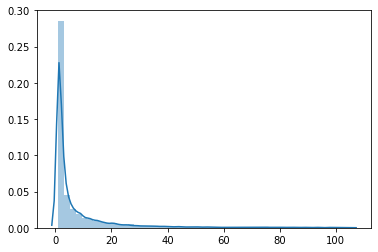

In [14]:
sns.distplot(list(num_words.values()));

В целом выглядит получше, больше похоже на распределение ципфа, давайте эти же слова просто удалим из текста.<br>
<b> Я не очень понял почему, но это сильно ухудшает качество, так что удалять ничего не будем, но код я оставил</b> 

In [15]:
# for i in tqdm(range(len(text))):
#     temp = text[i].split()
#     new_text = ''
#     for word in temp:
#         if word not in drop_words:
#             new_text = new_text + " " + word
#     text[i] = new_text

In [16]:
# # некоторые документы содержали только редкие слова, давайте просто удалим их
# drop_indexes = []
# for i in range(len(text)):
#     if text[i] == '':
#         drop_indexes.append(i)

# text = np.delete(text, drop_indexes)
# cats = np.delete(cats, drop_indexes)

## TF-IDF

In [17]:
# получим все уникальные слова еще раз, т.к. часть мы удалили
UniqueWords = set()
for i in range(len(text)):
    words = text[i].split()
    words = set(words)
    UniqueWords = UniqueWords.union(words)
    
print('Num Unique Words: {}'.format(len(UniqueWords)))

Num Unique Words: 19658


In [18]:
BagofWords = []
for i in tqdm(range(len(text))):
    temp = text[i].split()
    temp_words = dict.fromkeys(UniqueWords, 0)
    for word in temp:
        temp_words[word] += 1
    BagofWords.append(temp_words)

100%|██████████| 7769/7769 [00:09<00:00, 813.56it/s]


In [19]:
def get_TF(WordDict, BagofWords):
    tfDict = {}
    BagOfWordsCount = len(BagofWords)
    for word, count in WordDict.items():
        tfDict[word] = count / BagOfWordsCount
    return tfDict

In [20]:
TF = []
for i in tqdm(range(len(text))):
    temp = get_TF(BagofWords[i], text[i].split())
    TF.append(temp)

100%|██████████| 7769/7769 [00:40<00:00, 194.11it/s]


In [21]:
def get_IDF(text):
    N = len(text)
    
    idfDict = dict.fromkeys(text[0].keys(), 0)
    for document in text:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = np.log(N / val)
    return idfDict

In [22]:
IDF = get_IDF(BagofWords)

In [23]:
def get_TFIDF(TF, IDF):
    tfidf = {}
    for word, val in TF.items():
        tfidf[word] = val * IDF[word]
    return tfidf

In [24]:
TFIDF = []
for i in tqdm(range(len(text))):
    temp = get_TFIDF(TF[i], IDF)
    TFIDF.append(temp)

100%|██████████| 7769/7769 [01:39<00:00, 77.76it/s] 


In [25]:
import scipy
df = pd.DataFrame(TFIDF)
result = scipy.sparse.csr_matrix(df.values)

Давайте посмотрим на KNN для того что я руками сделал и что может выдать Sklearn чтобы проверить что примерно одно и то же получилось

In [26]:
# Ручной tfidf
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(result, cats)
model.score(result, cats)

0.8098854421418458

In [27]:
# sklearn tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
sklearn_tfidf = vectorizer.fit_transform(text)
model = KNeighborsClassifier()
model.fit(sklearn_tfidf, cats)
model.score(sklearn_tfidf, cats)

0.8428369159479985

Разница есть, видимо sklearn как-то по другому что-то считает и видимо эффективней. Я пробовал удалять редкие слова, но там совсем все плохо получается. Посмотрел просто глазами и цифры тоже разные получаются, возможно я что-то не так закодил или sklearn как-то по другому считает. В итоге лучше использовать из sklearn tfidf.

## SVM

In [28]:
# посмотрим как распределены классы
x = np.unique(cats, return_counts=True)[0]
y = np.unique(cats, return_counts=True)[1]
x, y

(array(['acq', 'acq coffee', 'acq crude', 'acq earn', 'acq pet-chem',
        'acq ship', 'acq sugar', 'acq trade', 'acq trade dlr money-fx',
        'alum', 'alum earn', 'alum nickel silver zinc lead copper',
        'barley corn grain', 'barley corn wheat grain', 'barley grain',
        'barley sorghum corn wheat grain',
        'barley sorghum soy-oil veg-oil meal-feed soybean oilseed wheat corn grain',
        'barley wheat', 'barley wheat corn grain', 'barley wheat grain',
        'bop', 'bop coffee gnp', 'bop gnp', 'bop trade', 'carcass',
        'carcass hog livestock', 'carcass l-cattle livestock',
        'carcass livestock', 'carcass livestock sugar grain',
        'carcass livestock veg-oil', 'castor-oil veg-oil oilseed', 'cocoa',
        'cocoa sugar coffee', 'cocoa sugar trade soybean oilseed coffee',
        'cocoa trade', 'coconut oilseed', 'coconut-oil palm-oil veg-oil',
        'coconut-oil palm-oil veg-oil soybean oilseed',
        'coconut-oil veg-oil', 'coconut-oil 

Классы распределены довольно плохо, давайте просто accuracy считать

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [30]:
%%time
# посмотрим сколько по времени займет и есть ли вообще смысл его считать
model = SVC()
model.fit(sklearn_tfidf, cats)
model.score(sklearn_tfidf, cats)

Wall time: 5min 20s


0.9115716308405201

По времени нормально работает, давайте посмотрим можно ли подобрать параметры часа за два

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sklearn_tfidf, cats)

In [32]:
import optuna
np.random.seed(42)

In [33]:
def objective(trial):
    C = trial.suggest_uniform('C', 0, 10)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    model = SVC(C=C, kernel=kernel, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)       
    return score

In [34]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=120*60, show_progress_bar=True)

[I 2020-11-10 12:16:11,492] A new study created in memory with name: no-name-18e4bffa-b5ee-4b5d-934c-09fd470a1fc2
C:\Users\Maksim_Krug\Anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



[I 2020-11-10 12:19:02,167] Trial 0 finished with value: 0.827071538857437 and parameters: {'C': 8.591326121930337, 'kernel': 'rbf'}. Best is trial 0 with value: 0.827071538857437.
[I 2020-11-10 12:20:14,144] Trial 1 finished with value: 0.8528049408131755 and parameters: {'C': 5.2821606866341675, 'kernel': 'linear'}. Best is trial 1 with value: 0.8528049408131755.
[I 2020-11-10 12:23:04,486] Trial 2 finished with value: 0.827071538857437 and parameters: {'C': 3.470276540950399, 'kernel': 'rbf'}. Best is trial 1 with value: 0.8528049408131755.
[I 2020-11-10 12:33:37,041] Trial 3 finished with value: 0.6906845084920227 and parameters: {'C': 7.452000969396794, 'kernel': 'poly'}. Best is trial 1 with value: 0.8528049408131755.
[I 2020-11-10 12:36:28,029] Trial 4 finished with value: 0.8265568708183222 and parameters: {'C': 4.630003982057169, 'kernel': 'rbf'}. Best is trial 1 with value: 0.8528049408131755.
[I 2020-11-10 12:46:41,863] Trial 5 finished with value: 0.6906845084920227 and par

[I 2020-11-10 13:57:08,779] Trial 41 finished with value: 0.8548636129696345 and parameters: {'C': 2.400210125728452, 'kernel': 'sigmoid'}. Best is trial 35 with value: 0.8564076170869789.
[I 2020-11-10 13:58:11,475] Trial 42 finished with value: 0.8564076170869789 and parameters: {'C': 2.712686860827791, 'kernel': 'sigmoid'}. Best is trial 35 with value: 0.8564076170869789.
[I 2020-11-10 13:59:13,973] Trial 43 finished with value: 0.8564076170869789 and parameters: {'C': 2.670832958304819, 'kernel': 'sigmoid'}. Best is trial 35 with value: 0.8564076170869789.
[I 2020-11-10 14:00:16,577] Trial 44 finished with value: 0.8548636129696345 and parameters: {'C': 2.3843914757054168, 'kernel': 'sigmoid'}. Best is trial 35 with value: 0.8564076170869789.
[I 2020-11-10 14:01:18,876] Trial 45 finished with value: 0.851775604734946 and parameters: {'C': 5.538609699656817, 'kernel': 'sigmoid'}. Best is trial 35 with value: 0.8564076170869789.
[I 2020-11-10 14:02:27,683] Trial 46 finished with valu

In [35]:
print('Best Params: {}, Best Score: {}'.format(study.best_params, study.best_value))

Best Params: {'C': 2.792803843546136, 'kernel': 'sigmoid'}, Best Score: 0.8564076170869789


In [36]:
# посмотрим на финальное качество
model = SVC(C=2.792803843546136, kernel='sigmoid', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)  
print('Model Score: {}'.format(score))

Model Score: 0.8564076170869789


В целом качество неплохое, хотя конечно не понятно какое оно должно быть. Давайте попробуем условный XGBoost и посмотрим что он даст чтобы понять хорошее ли у SVM качество

In [37]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)  
print('Model Score: {}'.format(score))

Model Score: 0.7900154400411734


XGBoost дает качество хуже, так что можем сделать вывод, что SVM в этой задаче скорее всего вполне неплох. Еще одно интересное наблюдение: SVM и XGBoost работает без перекодировки таргета, а например Logistic Regression требует перекодировать таргет, но да ладно

#### Мне все же не понятно почему sklearn работает не так как мой tfidf, давайте посмотрим на примере, который просто посчитать

In [80]:
import numpy as np
(np.log(2/1)) * 0.25

0.17328679513998632

In [45]:
text = ['my name is maksim', 'maksim lives here']

UniqueWords = set()
for i in range(len(text)):
    words = text[i].split()
    words = set(words)
    UniqueWords = UniqueWords.union(words)
    
BagofWords = []
for i in range(len(text)):
    temp = text[i].split()
    temp_words = dict.fromkeys(UniqueWords, 0)
    for word in temp:
        temp_words[word] += 1
    BagofWords.append(temp_words)
    
TF = []
for i in range(len(text)):
    temp = get_TF(BagofWords[i], text[i].split())
    TF.append(temp)
    
IDF = get_IDF(BagofWords)

TFIDF = []
for i in range(len(text)):
    temp = get_TFIDF(TF[i], IDF)
    TFIDF.append(temp)
    
print('MY TF:', TF)
print('MY IDF:', IDF)
print('MY TFIDF:', TFIDF)

MY TF: [{'my': 0.25, 'is': 0.25, 'lives': 0.0, 'maksim': 0.25, 'name': 0.25, 'here': 0.0}, {'my': 0.0, 'is': 0.0, 'lives': 0.3333333333333333, 'maksim': 0.3333333333333333, 'name': 0.0, 'here': 0.3333333333333333}]
MY IDF: {'my': 0.6931471805599453, 'is': 0.6931471805599453, 'lives': 0.6931471805599453, 'maksim': 0.0, 'name': 0.6931471805599453, 'here': 0.6931471805599453}
MY TFIDF: [{'my': 0.17328679513998632, 'is': 0.17328679513998632, 'lives': 0.0, 'maksim': 0.0, 'name': 0.17328679513998632, 'here': 0.0}, {'my': 0.0, 'is': 0.0, 'lives': 0.23104906018664842, 'maksim': 0.0, 'name': 0.0, 'here': 0.23104906018664842}]


Вроде все правильно, теперь посмотрим на sklearn

In [71]:
vectorizer = TfidfVectorizer(use_idf=True, norm='l1', smooth_idf=False, )
sklearn_tfidf = vectorizer.fit_transform(text)
sklearn_tfidf.toarray()

array([[0.        , 0.27850374, 0.        , 0.16448879, 0.27850374,
        0.27850374],
       [0.38600856, 0.        , 0.38600856, 0.22798288, 0.        ,
        0.        ]])

In [69]:
# что-то странное, посмотрим на TF
text = ['my name is maksim', 'maksim lives here']
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=False, norm='l1')
sklearn_tfidf = vectorizer.fit_transform(text)
sklearn_tfidf.toarray()

array([[0.        , 0.25      , 0.        , 0.25      , 0.25      ,
        0.25      ],
       [0.33333333, 0.        , 0.33333333, 0.33333333, 0.        ,
        0.        ]])

Sklearn выдает что-то странное, но работает вроде лучше. В итоге мне не очень понятно в чем разница, так что если честно я просто забил